Main figure of the Alborex Data paper in ESSD journal:         
positions of all the deployments (to keep it simple and clear).

In [1]:
import os
import glob
import json
import logging
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import colors
import datetime, time, calendar
import matplotlib.text as text
from matplotlib.path import Path
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import alborexdata
from importlib import reload

In [74]:
reload(alborexdata)

<module 'alborexdata' from '/home/ctroupin/Publis/201703_AlborexData/python/alborexdata.py'>

# Configuration
Most of the configuration (file paths, domain, resolution, ...) is done in the json file [`alborexconfig.json`](./alborexconfig.json).

In [76]:
with open('alborexconfig.json') as json_data_file:
    config = json.load(json_data_file)

## Logger

In [5]:
logger = alborexdata.configure_logging()
logger.setLevel(logging.DEBUG)
logging.info("Starting")

### Figures

In [6]:
figdir = config["figdir"]
figname = os.path.join(figdir, 'fig01')

## Time interval for the drifters

In [63]:
tt = datetime.datetime(2014, 5, 25, 0, 0, 0)
tt_end = datetime.datetime(2014, 6, 15, 0, 0, 0)

## Domain

In [64]:
coordinates = config["domain"]["coordinates1"]
coordinates2 = config["domain"]["coordinates2"]
dlon, dlat = config["domain"]["coordinates1"][0], config["domain"]["coordinates1"][1]

# Load data
## Coast

In [65]:
loncoast, latcoast = alborexdata.read_lonlat_coast(config["datafiles"]["coast"])

## Ship

In [66]:
rv = alborexdata.Ship()
rv.get_from_netcdf(config["datafiles"]["rv"])
rv.apply_qc()

## CTD

In [67]:
ctd = alborexdata.CTD()
ctd.get_from_netcdf(config["datafiles"]["ctd"])
lonCTD1, latCTD1 = alborexdata.load_lonloat_ctdleg("../data/ctd_positions_Leg1.txt")

## Gliders

In [68]:
glider1 = alborexdata.Glider()
glider1.get_from_netcdf(config["datafiles"]["gliders"][0])
glider2 = alborexdata.Glider()
glider2.get_from_netcdf(config["datafiles"]["gliders"][1])

## Drifters

In [69]:
drifterdir = config["datadirs"]["drifters"]
drifterlist = sorted(glob.glob(os.path.join(drifterdir, "*nc")))

## Profilers

In [82]:
profiler1 = alborexdata.Profiler()
profiler2 = alborexdata.Profiler()
profiler1.get_from_netcdf(config["datafiles"]["profilers"][0])
profiler2.get_from_netcdf(config["datafiles"]["profilers"][1])
profiler1.select_dates(initialdate=datetime.datetime(2014, 5, 30, 8, 0),
                       finaldate=drifterend)
profiler2.select_dates(initialdate=drifterstart,
                       finaldate=drifterend)

# Create the figure

/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4771: RuntimeWarning: invalid value encountered in greater
  lonsin = np.where(lonsin > lon_0+180, lonsin-360 ,lonsin)
/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4772: RuntimeWarning: invalid value encountered in less
  lonsin = np.where(lonsin < lon_0-180, lonsin+360 ,lonsin)
/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4776: RuntimeWarning: invalid value encountered in greater_equal
  itemindex = len(lonsin)-np.where(londiff>=thresh)[0]


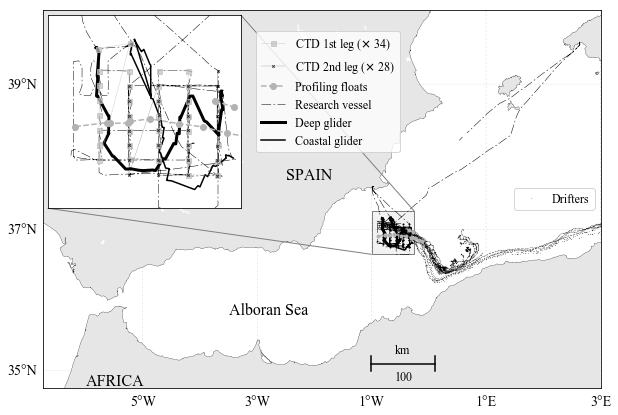

In [101]:
fig, m, ax = alborexdata.prepare_map(coordinates, 'h')
fig.set_size_inches(10, 10)

# Map scale
m.drawmapscale(-0.45, 35.1, -0.25, 35.1, 100, barstyle='simple', 
               units='km', fontsize=12, zorder=3)

# Labels
xa1, ya1 = m(-2.5, 37.7)
ax.annotate("SPAIN", xy=(xa1,ya1), xytext=(xa1,ya1),
            xycoords='data', textcoords='data', fontsize=16
            )
xa1, ya1 = m(-6, 34.8)
xa2, ya2 = m(-6, 34.8)
ax.annotate("AFRICA", xy=(xa1,ya1), xytext=(xa2,ya2),
            xycoords='data', textcoords='data', fontsize=16
            )
xa1, ya1 = m(-3.5, 35.8)
xa2, ya2 = m(-3.5, 35.8)
ax.annotate("Alboran Sea", xy=(xa1,ya1), xytext=(xa2,ya2),
            xycoords='data', textcoords='data', fontsize=16,
            zorder=7
            )
# Add drifter trajectories on map
for drifterfile in drifterlist:
    drifter = alborexdata.Drifter()
    drifter.get_from_netcdf(drifterfile)
    
    # Take only good time
    drifter.select_dates(initialdate=drifterstart, finaldate=drifterend)
    if drifterfile == drifterlist[0]:
        m.plot(drifter.lon.compressed(), drifter.lat.compressed(), 
               'ko', ms=0.1, alpha=.85, zorder=5, latlon=True, label="Drifters")
    else:
        m.plot(drifter.lon.compressed(), drifter.lat.compressed(), 
               'ko', ms=0.1, alpha=.85, zorder=5, latlon=True)
        
    
# CTD
m.plot(ctd.lon, ctd.lat, 'ko', ms=1, zorder=6, latlon=True)

# Glider
llong1, llatg1 = m(glider1.lon.compressed(), glider1.lat.compressed())
llong2, llatg2 = m(glider2.lon.compressed(), glider2.lat.compressed())

m.plot(glider1.lon.compressed(), glider1.lat.compressed(), 
       '-', lw=3, color='k', zorder=3, latlon=True)
m.plot(glider2.lon.compressed(), glider2.lat.compressed(), 
       '-', lw=1.5, color='k', zorder=3, latlon=True)

# Profilers
lonp1, latp1 = m(profiler1.lon, profiler1.lat)
lonp2, latp2 = m(profiler2.lon, profiler2.lat)

m.plot(profiler1.lon, profiler1.lat, "o--", zorder=6,
       color=".7", latlon=True, ms=3)
m.plot(profiler2.lon, profiler2.lat, "o--", zorder=6,
       color=".7", latlon=True, ms=3)

# Ship trajectory
lonrv, latrv = m(rv.lon.compressed(), rv.lat.compressed())
m.plot(rv.lon, rv.lat, 'k-.', linewidth=.5, latlon=True)

# Coastline and continent
for i in range(0, len(loncoast)):
    m.plot(np.array(loncoast[i]), np.array(latcoast[i]), 
           color='k', linewidth=.25, latlon=True)

m.fillcontinents(ax=ax, color='0.9', zorder=2)
m.drawcountries(linewidth=.2, color="k")

# Add rectangle around study area
patch = alborexdata.create_rect_patch(coordinates2, m, color=".95")
ax.add_patch(patch)

# Plot inset with CTD and gliders
axins = zoomed_inset_axes(ax, 4.5, loc=2)
n1, n2 = m(coordinates2[0], coordinates2[2])
n3, n4 = m(coordinates2[1], coordinates2[3])
axins.set_xlim(n1, n3)
axins.set_ylim(n2, n4)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

# Add gliders tracks and CTD casts
NN = 34

llon, llat = m(ctd.lon[:NN], ctd.lat[:NN])
axins.plot(llon, llat, 'ks-', lw=0.5, color=".75", ms=5, 
           zorder=4, label=r"CTD 1st leg ($\times$ 34)", alpha=.7)
llon, llat = m(ctd.lon[NN:], ctd.lat[NN:])
axins.plot(llon, llat, 'kx-', lw=0.2, ms=2.5, 
           zorder=4, label=r"CTD 2nd leg ($\times$ 28)",
           alpha=.7)


axins.plot(lonp1, latp1, "o--", zorder=6, color=".7", label="Profiling floats")
axins.plot(lonp2, latp2, "o--", zorder=6, color=".7")
axins.plot(lonrv, latrv, 'k-.', linewidth=.5, label="Research vessel")
axins.plot(llong1, llatg1, '-', lw=3, color='k', zorder=3, label="Deep glider", )
axins.plot(llong2, llatg2, '-', lw=1.5, color='k', zorder=3, label="Coastal glider")
axins.legend(bbox_to_anchor=(1.05, .95), fontsize=12)

#axins.plot(londriftertotal / ndrifters, latdriftertotal / ndrifters, 'ko', ms=0.1,
#           label=r"Drifters ($\times$ 25)")
mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.5")
ax.legend(loc=7, fontsize=12)

alborexdata.add_map_grid(m, coordinates, dlon=2., dlat=2.,
                         fontname='Times New Roman', fontsize=14, 
                         linewidth=0.2, zorder=1, color=".6")
plt.savefig(figname, dpi=300, bbox_inches='tight', transparent=False,
            edgecolor='white', pad_inches=0)
plt.show()
plt.close()